# Photoplethysmogram(PPG) processing pipeline *Python*

Created on 20201.7.10 by Rain. This notebook this for the physiological data processing of the VR Emotion project

The raw data we will use were obtained from BIOPAC MP160, and first exported in a mat format for segmentation.

Generally, I think the biosinal processing pipeline are basically the same for different kind of data, while the feature extraction can be different. 

In this script, the PPG analysis are mainly conducted by neurokit2, for preprocessing and feature extraction.
Overview:
Step 1: Import raw data
Step 2: Flatten the data & Downsampling
Step 3: Clean the raw data

# Part 1: A step-by step guide for PPG processing

# Step 1: Import the raw data

In [1]:
import neurokit2 as nk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import loadmat
%matplotlib inline
data = loadmat('F:/1_Emotion_Data/Physiology/Helpless/sub_001_helpless_1.mat')
plt.rcParams['figure.figsize'] = [15, 9]  # Bigger images
plt.rcParams['font.size']= 13

In [2]:
# Let's take a look of our current dataset
print(data);print(type(data));print(data.keys());

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Mon Jun 21 13:57:21 2021', '__version__': '1.0', '__globals__': [], 'ecg_hl1': array([[0.07568359],
       [0.07614136],
       [0.0769043 ],
       ...,
       [0.04180908],
       [0.04226685],
       [0.04364014]]), 'eda_hl1': array([[11.65466267],
       [11.6592403 ],
       [11.65466267],
       ...,
       [11.64703327],
       [11.64703327],
       [11.64398151]]), 'emg_hl1': array([[ 0.00457764],
       [ 0.00030518],
       [-0.01846313],
       ...,
       [-0.00091553],
       [ 0.00045776],
       [ 0.00091553]]), 'emgc_hl1': array([[1.08489990e-04],
       [9.27734375e-05],
       [8.66699219e-05],
       ...,
       [4.30297852e-05],
       [3.71551514e-05],
       [3.39508057e-05]]), 'hr_hl1': array([[83.79888268],
       [83.79888268],
       [83.79888268],
       ...,
       [85.04606662],
       [85.04606662],
       [85.04606662]]), 'ppg_hl1': array([[-0.00091553],
       [-0.00091553],
       [-0.

## *Primarily, we can see that within each mat file, the multimodality physiological data were stored into a numpy array individually*

# Step 2: Flatten the data array & Downsampling accrodingly(if needed)

In [3]:
# Obtain the ppg data from the dataset
ppg=data['ppg_hl1'];
# Have a check of its original shape
print(ppg.shape)

(216001, 1)


In [4]:
## For downsampling and further processing, we should flatten the 2-D array into a 1-D array
ppg=np.ndarray.flatten(ppg);ppg.shape 

(216001,)

In [34]:
# Here the neurokit downssampling functionwas used, in the manner of numpy downsampling
ppg = nk.signal_resample(ppg, method="numpy",sampling_rate=2000, desired_sampling_rate=200)
# Check the shape again after downsampling and faltten
print(ppg.shape)

(21600,)


# Step 3: Clean the raw PPG data

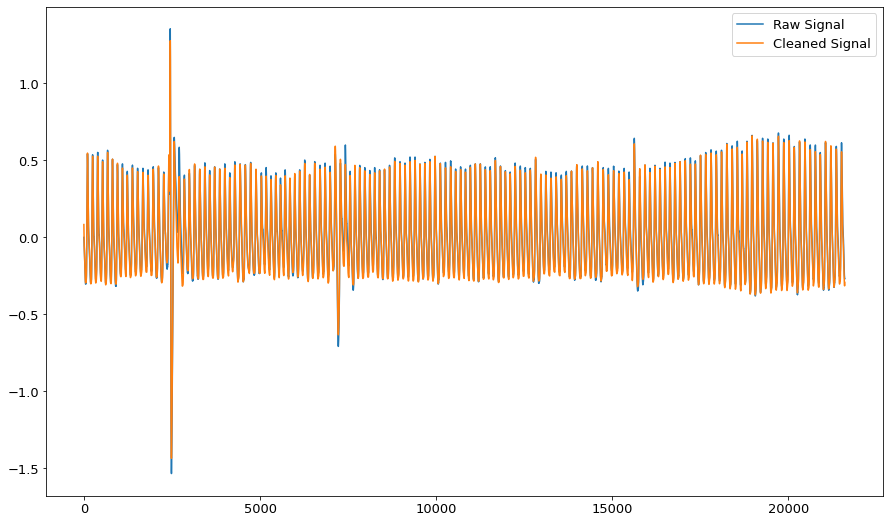

In [36]:
# Clean the raw signal 
ppg_cleaned=nk.ppg_clean(ppg,sampling_rate=200)
# Plot the raw signal and cleaned signal ogether
plt.plot(ppg,label='Raw Signal')
plt.plot(ppg_cleaned,label='Cleaned Signal')
plt.legend()

# Step 4: Locate the peaks of the cleaned PPG signal

[  103   248   392   532   674   813   953  1095  1232  1379  1525  1676
  1822  1969  2117  2267  2452  2563  2706  2853  2994  3143  3289  3435
  3571  3712  3856  4001  4142  4286  4435  4583  4734  4886  5038  5174
  5311  5448  5581  5713  5849  5985  6125  6270  6408  6554  6704  6847
  6989  7136  7283  7423  7557  7693  7831  7974  8117  8254  8394  8534
  8677  8824  8973  9117  9258  9400  9540  9679  9821  9968 10118 10265
 10411 10552 10694 10832 10970 11110 11254 11396 11535 11680 11825 11964
 12100 12242 12389 12531 12672 12822 12971 13113 13259 13404 13552 13694
 13840 13992 14147 14293 14438 14589 14741 14888 15037 15186 15337 15478
 15624 15778 15927 16068 16211 16353 16497 16637 16779 16922 17069 17217
 17358 17504 17651 17803 17952 18100 18251 18401 18548 18685 18824 18968
 19116 19266 19413 19561 19715 19867 20020 20165 20314 20468 20619 20764
 20904 21053 21204 21359 21507]


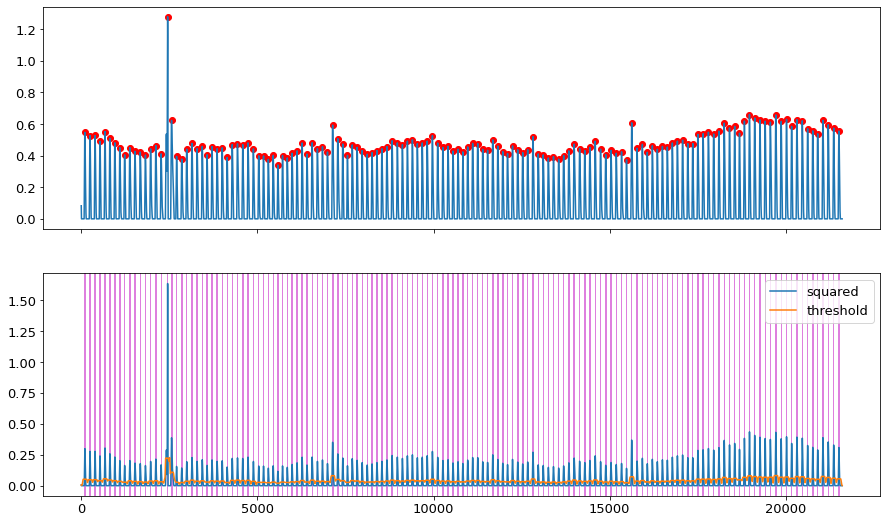

In [25]:
peak_info=nk.ppg_findpeaks(ppg_cleaned,sampling_rate=200,show=True)
peaks=peak_info['PPG_Peaks']; print(peaks)
# We should note that the peak info only provide the timepoint of the peak value, we should further match it into the raw data for further analysis

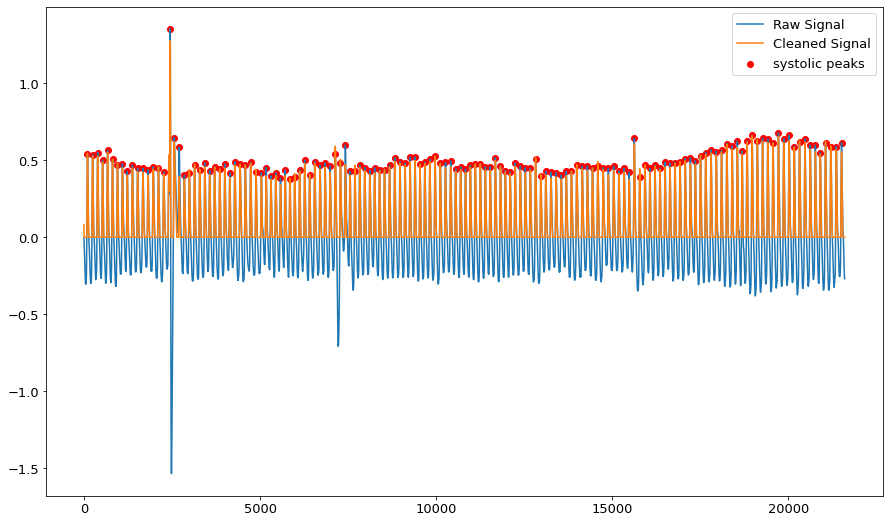

In [27]:
# Construct a empty matrix of the same size with the signal and match the peaks into it
peaks_signal=np.zeros(ppg.shape);
peaks_signal[peaks]=1;
# Let's plot the raw signal, cleaned signal and the peaks altogether
plt.plot(ppg,label='Raw Signal')
plt.plot(ppg_cleaned,label='Cleaned Signal')
plt.scatter(peaks, ppg[peaks], c="r", label="systolic peaks")
plt.legend()

# Step 5 : Compute the signal rate

In [39]:
# By using the rate function, we can obtain the the signal rate from a series of peak
rate=nk.ppg_rate(peaks,sampling_rate=200,desired_length=len(ppg_cleaned))
print(rate)

[82.97514483 82.97514483 82.97514483 ... 81.08108108 81.08108108
 81.08108108]


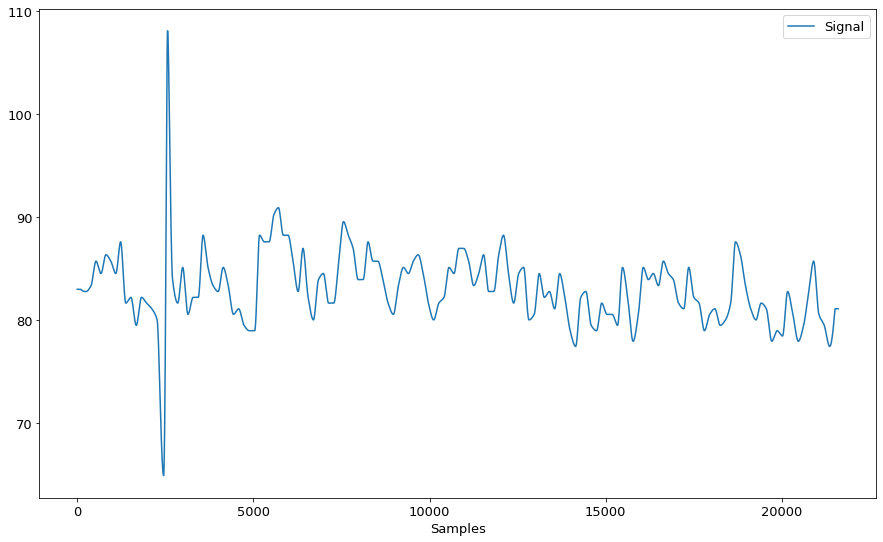

In [40]:
# Plot the signal ate
nk.signal_plot(rate)

# Step 6: Aggregate the data and plot

In [41]:
# Aggregate the results into one dataframe
signals=pd.DataFrame({"PPG_Raw":ppg,"PPG_Clean":ppg_cleaned,"PPG_Rate":rate,"PPG_Peaks":peaks_signal})

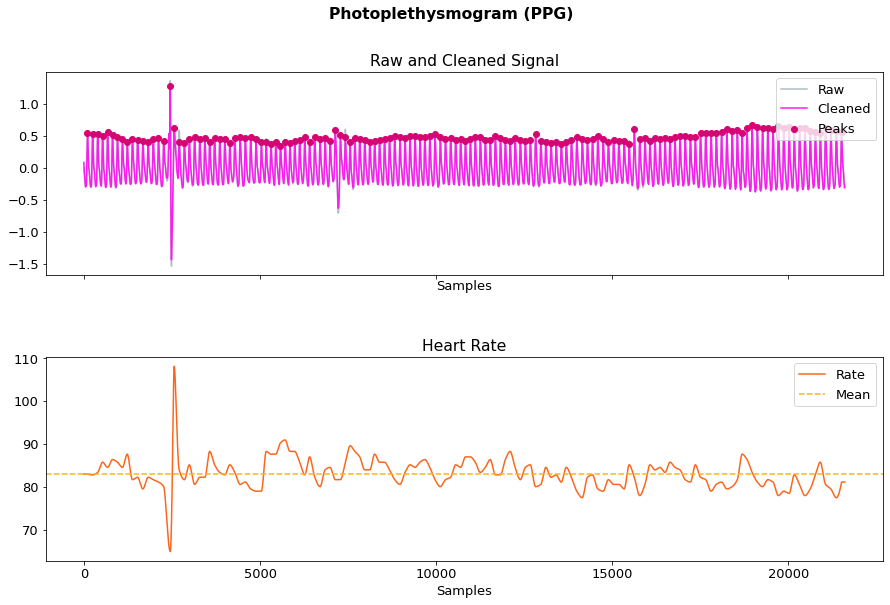

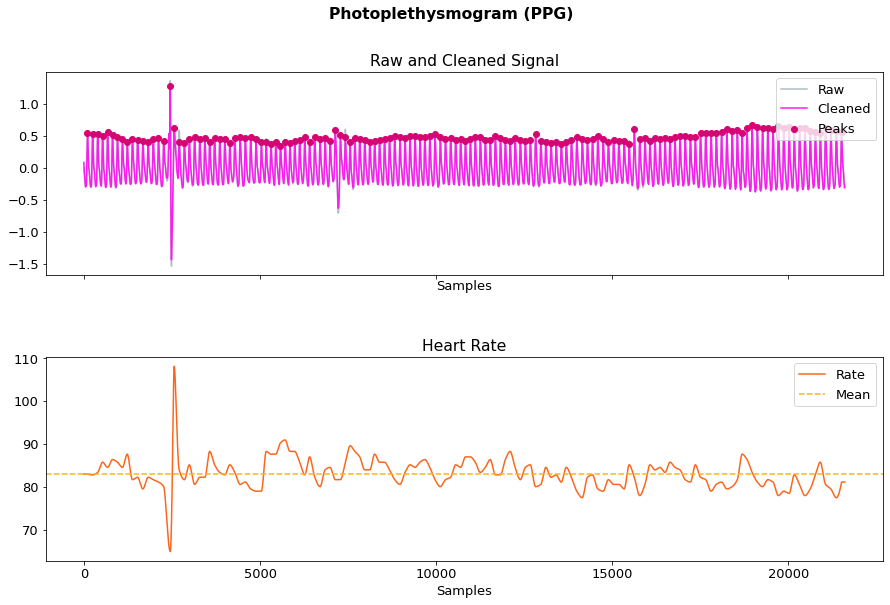

In [42]:
nk.ppg_plot(signals)

# Step 7: Analyze and extract the PPG features (interval realted in this case)

In [43]:
# Obtain the ppg features
ppg_features=nk.ppg_intervalrelated(signals,sampling_rate=200)

In [44]:
ppg_features

,PPG_Rate_Mean,HRV_MeanNN,HRV_SDNN,HRV_SDANN1,HRV_SDNNI1,HRV_SDANN2,HRV_SDNNI2,HRV_SDANN5,HRV_SDNNI5,HRV_RMSSD,...,HRV_SampEn,HRV_ShanEn,HRV_FuzzyEn,HRV_MSE,HRV_CMSE,HRV_RCMSE,HRV_CD,HRV_HFD,HRV_KFD,HRV_LZC
0,83.002506,723.108108,32.988379,NaN,NaN,NaN,NaN,NaN,NaN,42.68019,...,1.867081,4.301226,1.206369,0.0,1.52028,1.538852,1.031222,1.765677,2.296006,0.97425


# Part 2: Build customized function for PPG processing

In [5]:
def rain_ppg(ppg, fs, dfs):
    # Import the raw data(1-D array), downsampling first, fs denotes the originial fs, while dfs denotes the desired fs
    ppg = nk.signal_resample(ppg, method="numpy",sampling_rate=fs, desired_sampling_rate=dfs)
    # Clean the raw signal
    ppg_cleaned = nk.ppg_clean(ppg,sampling_rate=dfs)
    # Find the peaks of the PPG signal
    peak_info = nk.ppg_findpeaks(ppg_cleaned,sampling_rate=dfs,show=False)
    # Match the peak location into the timeseries
    peaks = peak_info['PPG_Peaks']; peaks_signal = np.zeros(ppg.shape); peaks_signal[peaks] = 1
    # Calculate the signal rate
    rate = nk.ppg_rate(peaks,sampling_rate=dfs,desired_length=len(ppg_cleaned))
    # Aggregate the results to a dataframe
    signals = pd.DataFrame({"PPG_Raw":ppg,"PPG_Clean":ppg_cleaned,"PPG_Rate":rate,"PPG_Peaks":peaks_signal})
    # Obtain the PPG features
    ppg_features = nk.ppg_intervalrelated(signals,sampling_rate=dfs)
    return signals, ppg_features